## MSBA 326:  SVN
Evan Uribe<br>
11/7/19


In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

### 5. Use the Wine dataset (the same code as the one in the midterm exam) and add<br> 
 - an SV Classifier(SVC), <br>
 - a random forest classifier with a depth of 2 and <br>
 - an Adaboost classifier <br>
and compare them using kfold cross validation with k=10.<br> 
For the SVC, use the default settings given in the sample code, use RFB kernel with C = 1.0.<br> 
(Hint: check the documentation for multi-class classification using SVM: http://scikit-learn.org/stable/auto_examples/plot_multilabel.html#sphx-glr-auto-examples-plot-multilabel-py)


In [2]:
# load dataset
filename = ('~/Documents/workspace/ggu/data/Course Data/wine.csv')  
colnames = ['class', 'Alcohol', 'Malic acid', 'Ash', 'Alkalinity of ash', 'Magnesium', 
                      'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
                     'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
wine = read_csv(filename, names=colnames)
wine.head(3)


,class,Alcohol,Malic acid,Ash,Alkalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


In [46]:
# get inputs and outputs
array = wine.values
X = array[:,1:14] 
Y = array[:,0]   # wine classes (1-3)

# prepare models
models = []
models.append(('Kernel rbf', SVC(kernel = 'rbf', degree = 2, C=1.0, random_state=1))) # SV Classifier
models.append(('Random Forest', RandomForestClassifier(max_depth=2, random_state=0))) # Random forest with a depth of 2

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), 
                             n_estimators=50, algorithm="SAMME.R",
                             learning_rate=1,random_state=None)
models.append(('AdaBoost', ada_clf))

from time import time
names = []
results = []

# evaluate each model in turn
# cross_val_score helper function that will iterate over 10 folds (specified) 
def getAccuracy(models):
    
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=7)  
        start = time()
        cv_results = cross_val_score(model, X, Y, cv=kfold, 
                    scoring='accuracy') #https://scikit-learn.org/stable/modules/model_evaluation.html
                                
        end = time()
        results.append(cv_results)
        names.append(name)
        print("%s: %f (%f) <time=%f>" % (name, cv_results.mean(), cv_results.std(), end - start))   
    #print (results)
    
getAccuracy(models)


Kernel rbf: 0.172876 (0.186266) <time=0.065481>
Random Forest: 0.847712 (0.133069) <time=0.099837>
AdaBoost: 0.899020 (0.086159) <time=0.724558>



### 6. Plot all the accuracy results vs. each model (model type on the x-axis and accuracy on the y-axis).

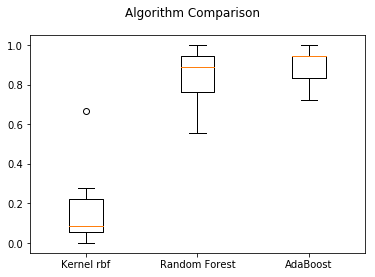

In [47]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Adaboost has the highest accuracy, followed by Random Forest.
RBF has the lowest accuracy but best time performance.


### 7. Try a polynomial kernel by setting kernel = ‘poly’ and change the kernel degree from 2 – 5.

In [15]:
models = []
degrees = [2, 3, 4, 5]

for deg in degrees:
     svc = SVC(kernel = 'poly', degree = deg, C=1.0, random_state=1, probability=True)
     models.append(('poly^' + str(deg), svc))



### 8. Compare the results with the RBF kernel and the same value of C=1.0

In [16]:
svc=SVC(kernel = 'rbf', C=1.0, random_state=1, probability=True)
models.append(('rbf', svc)) 

names = []
results = []
getAccuracy(models)

poly^2: 0.950000 (0.058002) <time=9.388929>
poly^3: 0.949346 (0.058719) <time=8.014307>
poly^4: 0.938235 (0.072700) <time=8.717355>
poly^5: 0.926797 (0.076028) <time=11.969165>
rbf: 0.172876 (0.186266) <time=0.096081>


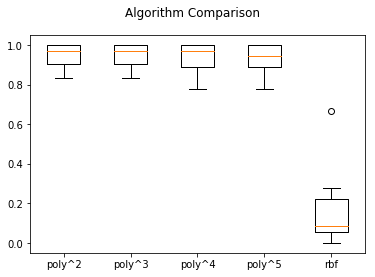

In [17]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


### 9. Write down your observation on the comparison results.

For polynomial, increasing degrees leads to longer times and decreased accuracy. <br>
RBF performs best in terms of time but has the worst accuracy


## 10. Plot the multi-class ROC curve and use the roc_auc_score function to calculate ROC score.


In [21]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
# https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Plot of a ROC curve for a specific class
def plotROCMultiClass (clf, clfName):
    y = label_binarize(Y, classes=[1, 2, 3])
    n_classes = 3

    y_scores = cross_val_predict(clf, X, Y, cv=10, method="predict_proba")
    # your X.shape is (m, n), your y.shape should be (m). Does this match
    #X.shape # (178, 13) #Y.shape # (178,)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        title = '(%s) Area Under Curve (AUC) class%d: %f' %(clfName,i, roc_auc_score(y[:, i], y_scores[:, i]))
        plt.title(title)
        plt.legend(loc="lower right")

        
#clf = SVC(kernel = 'rbf', C=1.0, random_state=1, probability=True)
#plotROCMultiClass (clf, 'rbf')

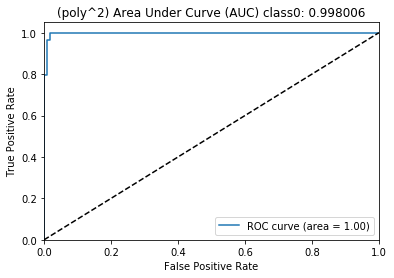

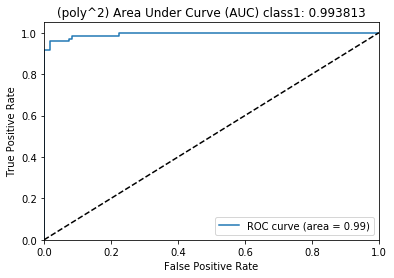

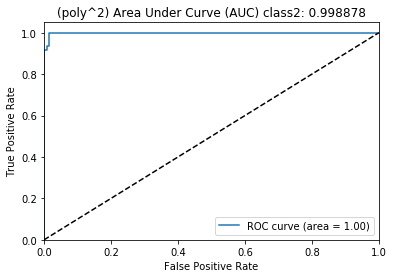

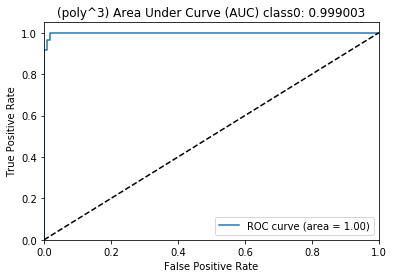

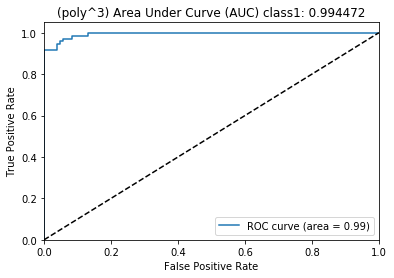

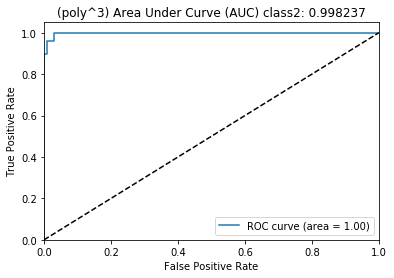

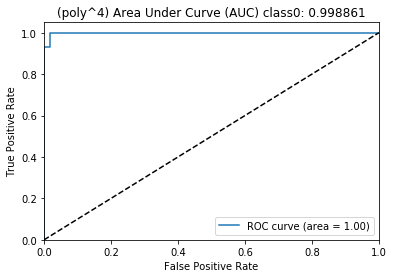

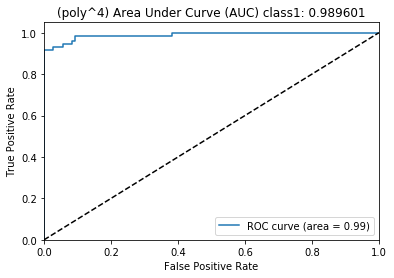

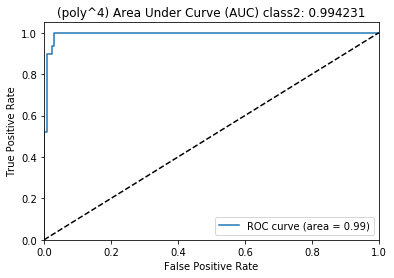

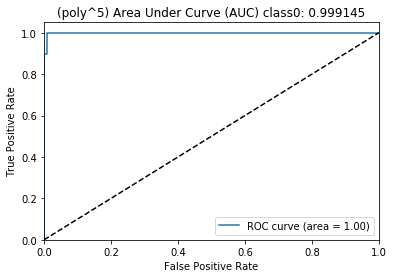

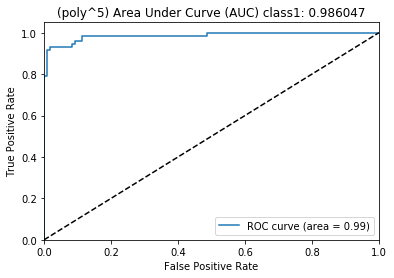

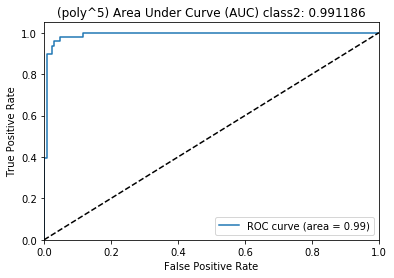

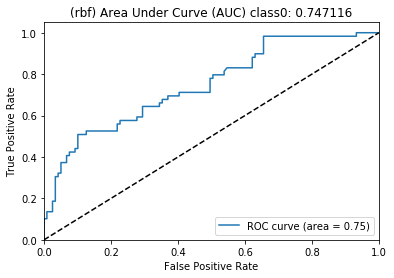

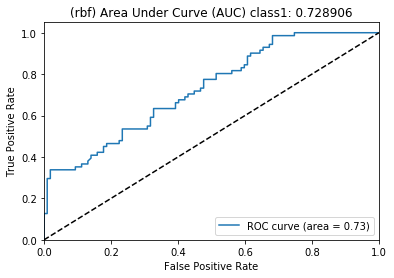

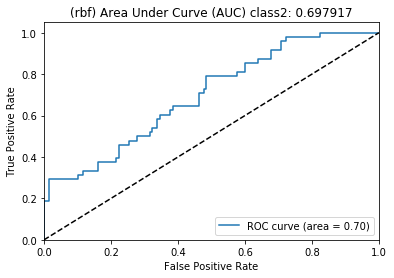

In [22]:
for i in range(len(models)):
    cname= models[i][0]
    m = models[i][1]
    plotROCMultiClass (m, cname)

References<br>
https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/<br>
https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html<br>
https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html<br>
https://www.pythonforengineers.com/cross-validation-and-model-selection/<br>


### PCA (principal component analysis)

https://sebastianraschka.com/Articles/2014_scikit_dataprocessing.html#linear-transformation-principal-component-analysis-pca

The main purposes of a PCA are the analysis of data to identify patterns and finding patterns to reduce the dimensions of the dataset with minimal loss of information.

Here, our desired outcome of the PCA is to project a feature space (our dataset consisting of n x d-dimensional samples) onto a smaller subspace that represents our data “well”. A possible application would be a pattern classification task, where we want to reduce the computational costs and the error of parameter estimation by reducing the number of dimensions of our feature space by extracting a subspace that describes our data “best”.

Here, we will use the sklearn.decomposition.PCA to transform our training data onto 2 dimensional subspace:

In [10]:
all_data = wine.values
# load class labels from column 1
y_wine = all_data[:,0]

# conversion of the class labels to integer-type array
y_wine = y_wine.astype(np.int64, copy=False)

# load the 14 features
X_wine = all_data[:,1:]

# printing some general information about the data
print('\ntotal number of samples (rows):', X_wine.shape[0])
print('total number of features (columns):', X_wine.shape[1])

# printing the 1st wine sample
float_formatter = lambda x: '{:.2f}'.format(x)
np.set_printoptions(formatter={'float_kind':float_formatter})
print('\n1st sample (i.e., 1st row):\nClass label: {:d}\n{:}\n'
          .format(int(y_wine[0]), X_wine[0]))

# printing the rel.frequency of the class labels
print('Class label frequencies')
print('Class 1 samples: {:.2%}'.format(list(y_wine).count(1)/y_wine.shape[0]))
print('Class 2 samples: {:.2%}'.format(list(y_wine).count(2)/y_wine.shape[0]))
print('Class 3 samples: {:.2%}'.format(list(y_wine).count(3)/y_wine.shape[0]))



total number of samples (rows): 178
total number of features (columns): 13

1st sample (i.e., 1st row):
Class label: 1
[14.23 1.71 2.43 15.60 127.00 2.80 3.06 0.28 2.29 5.64 1.04 3.92 1065.00]

Class label frequencies
Class 1 samples: 33.15%
Class 2 samples: 39.89%
Class 3 samples: 26.97%


## Scatterplots
Scatter plots are useful for visualizing features in more than just one dimension, for example to get a feeling for the correlation between particular features.
Unfortunately, we can’t plot all 13 features here at once, since the visual cortex of us humans is limited to a maximum of three dimensions.

Below, we will create an example 2D-Scatter plot from the features “Alcohol content” and “Malic acid content”.
Additionally, we will use the scipy.stats.pearsonr function to calculate a Pearson correlation coefficient between these two features.

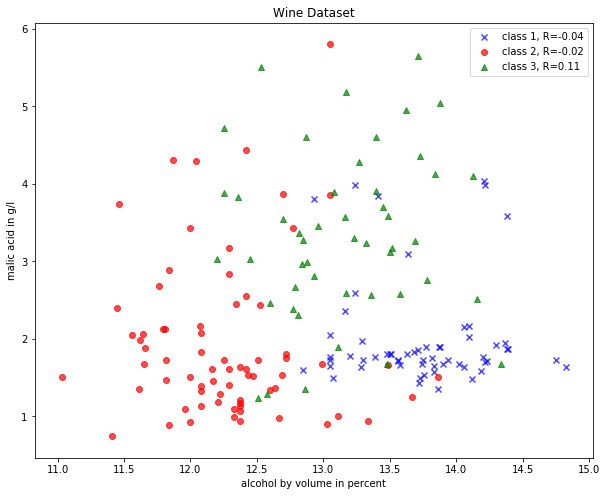

In [13]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

plt.figure(figsize=(10,8))

for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue', 'red', 'green')):

    # Calculate Pearson correlation coefficient
    R = pearsonr(X_wine[:,0][y_wine == label], X_wine[:,1][y_wine == label])
    plt.scatter(x=X_wine[:,0][y_wine == label], # x-axis: feat. from col. 1
                y=X_wine[:,1][y_wine == label], # y-axis: feat. from col. 2
                marker=marker, # data point symbol for the scatter plot
                color=color,
                alpha=0.7,
                label='class {:}, R={:.2f}'.format(label, R[0]) # label for the legend
                )

plt.title('Wine Dataset')
plt.xlabel('alcohol by volume in percent')
plt.ylabel('malic acid in g/l')
plt.legend(loc='upper right')

plt.show()

## Splitting into training and test dataset
It is a typical procedure for machine learning and pattern classification tasks to split one dataset into two: a training dataset and a test dataset.
The training dataset is henceforth used to train our algorithms or classifier, and the test dataset is a way to validate the outcome quite objectively before we apply it to “new, real world data”.

Here, we will split the dataset randomly so that 70% of the total dataset will become our training dataset, and 30% will become our test dataset, respectively.

In [36]:
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine,
     test_size=0.30, random_state=123)

Note that since this a random assignment, the original relative frequencies for each class label are not maintained.

In [16]:
print('Class label frequencies')

print('\nTraining Dataset:')    
for l in range(1,4):
    print('Class {:} samples: {:.2%}'.format(l, list(y_train).count(l)/y_train.shape[0]))

print('\nTest Dataset:')     
for l in range(1,4):
    print('Class {:} samples: {:.2%}'.format(l, list(y_test).count(l)/y_test.shape[0]))

Class label frequencies

Training Dataset:
Class 1 samples: 36.29%
Class 2 samples: 42.74%
Class 3 samples: 20.97%

Test Dataset:
Class 1 samples: 25.93%
Class 2 samples: 33.33%
Class 3 samples: 40.74%


## Feature Scaling
### Standardization
Another important procedure is to standardize the data prior to fitting the model and other analyses so that the features will have the properties of a standard normal distribution with

μ=0 and σ=1
where μ is the mean (average) and σ is the standard deviation from the mean; standard scores (also called z scores) of the samples are calculated as follows:

z=(x−μ)/σ

Standardizing the features so that they are centered around 0 with a standard deviation of 1 is especially important if we are comparing measurements that have different units, e.g., in our “wine data” example, where the alcohol content is measured in volume percent, and the malic acid content in g/l.

In [ ]:
std_scale = preprocessing.StandardScaler().fit(X_train)

X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

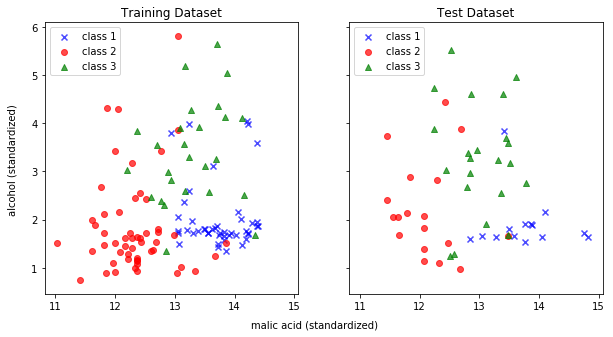

In [17]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))

for a,x_dat, y_lab in zip(ax, (X_train, X_test), (y_train, y_test)):

    for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue','red','green')):

        a.scatter(x=x_dat[:,0][y_lab == label],
                y=x_dat[:,1][y_lab == label],
                marker=marker,
                color=color,   
                alpha=0.7,   
                label='class {}'.format(label)
                )

    a.legend(loc='upper left')

ax[0].set_title('Training Dataset')
ax[1].set_title('Test Dataset')
f.text(0.5, 0.04, 'malic acid (standardized)', ha='center', va='center')
f.text(0.08, 0.5, 'alcohol (standardized)', ha='center', va='center', rotation='vertical')

plt.show()

### Min-Max scaling (Normalization)
An alternative approach to standardization is the so-called Min-Max scaling (sometimes also referred to as “normalization”).
In this approach, the data is scaled to a fixed range - usually 0 to 1.
The cost of having this bounded range - in contrast to standardization - is that we will end up with small standard deviations, for example in the case where outliers are present.

The equation to calculate the “normalized” score is:

X′= (X−Xmin)/(Xmax−Xmin)

In [25]:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_train)

X_train_minmax = minmax_scale.transform(X_train)
X_test_minmax = minmax_scale.transform(X_test)

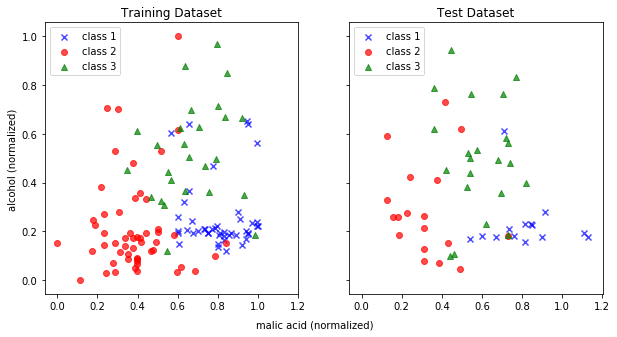

In [26]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))

for a,x_dat, y_lab in zip(ax, (X_train_minmax, X_test_minmax), (y_train, y_test)):

    for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue','red','green')):

        a.scatter(x=x_dat[:,0][y_lab == label],
                y=x_dat[:,1][y_lab == label],
                marker=marker,
                color=color,   
                alpha=0.7,   
                label='class {}'.format(label)
                )

    a.legend(loc='upper left')

ax[0].set_title('Training Dataset')
ax[1].set_title('Test Dataset')
f.text(0.5, 0.04, 'malic acid (normalized)', ha='center', va='center')
f.text(0.08, 0.5, 'alcohol (normalized)', ha='center', va='center', rotation='vertical')

plt.show()


## Linear Transformation: Principal Component Analysis (PCA)

The main purposes of a principal component analysis are the analysis of data to identify patterns and finding patterns to reduce the dimensions of the dataset with minimal loss of information.

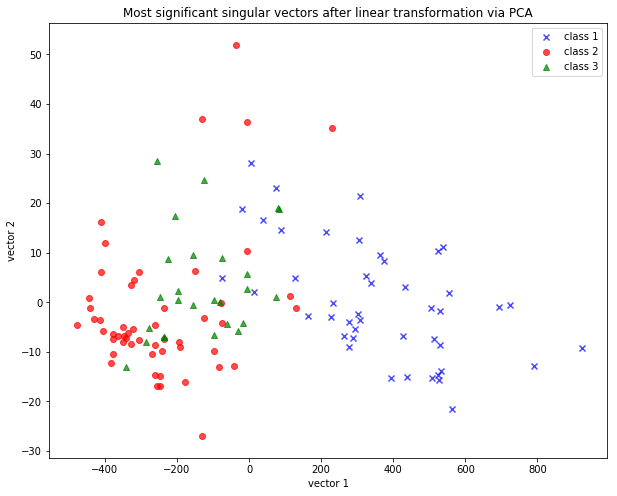

In [22]:
from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components=2) # number of components to keep
sklearn_transf = sklearn_pca.fit_transform(X_train)

plt.figure(figsize=(10,8))

for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue', 'red', 'green')):

    plt.scatter(x=sklearn_transf[:,0][y_train == label],
                y=sklearn_transf[:,1][y_train == label],
                marker=marker,
                color=color,
                alpha=0.7,
                label='class {}'.format(label)
                )

plt.xlabel('vector 1')
plt.ylabel('vector 2')

plt.legend()
plt.title('Most significant singular vectors after linear transformation via PCA')

plt.show()

### PCA for feature extraction
As mentioned, PCA is commonly used in the field of pattern classification for feature selection (or dimensionality reduction).
By default, the transformed data will be ordered by the components with the maximum variance (in descending order).

In the example above, I only kept the top 2 components (the 2 components with the maximum variance along the axes): The sample space of projected onto a 2-dimensional subspace, which was basically sufficient for plotting the data onto a 2D scatter plot.

However, if we want to use PCA for feature selection, we probably don’t want to reduce the dimensionality that drastically. By default, the PCA function (PCA(n_components=None)) keeps all the components in ranked order. So we could basically either set the number n_components to a smaller size then the input dataset, or we could extract the top n components later from the returned NumPy array.

To get an idea about how well each components (relatively) “explains” the variance, we can use explained_variance_ratio_ instant method, which also confirms that the components are ordered from most explanatory to least explanatory (the ratios sum up to 1.0).

In [27]:
sklearn_pca = PCA(n_components=None)
sklearn_transf = sklearn_pca.fit_transform(X_train)

sklearn_pca.explained_variance_ratio_

array([1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
       0.00, 0.00])

In [33]:
wine.columns

Index(['class', 'Alcohol', 'Malic acid', 'Ash', 'Alkalinity of ash',
       'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

## Linear Transformation: Linear Discriminant Analysis (MDA)

The main purposes of a Linear Discriminant Analysis (LDA) is to analyze the data to identify patterns to project it onto a subspace that yields a better separation of the classes. Also, the dimensionality of the dataset shall be reduced with minimal loss of information.

The approach is very similar to a Principal Component Analysis (PCA), but in addition to finding the component axes that maximize the variance of our data, we are additionally interested in the axes that maximize the separation of our classes (e.g., in a supervised pattern classification problem)

Here, our desired outcome of the Linear discriminant analysis is to project a feature space (our dataset consisting of n d-dimensional samples) onto a smaller subspace that represents our data “well” and has a good class separation. A possible application would be a pattern classification task, where we want to reduce the computational costs and the error of parameter estimation by reducing the number of dimensions of our feature space by extracting a subspace that describes our data “best”.

Like we did in the PCA section above, we will use a scikit-learn funcion, sklearn.lda.LDA in order to transform our training data onto 2 dimensional subspace:

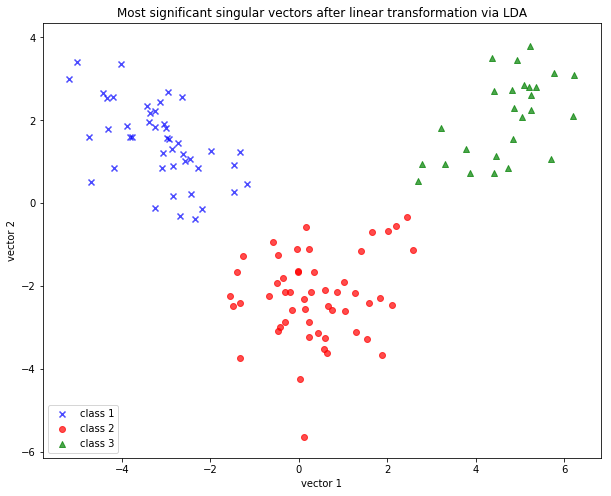

In [34]:
#from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sklearn_lda = LDA(n_components=2)
transf_lda = sklearn_lda.fit_transform(X_train, y_train)

plt.figure(figsize=(10,8))

for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue', 'red', 'green')):

    plt.scatter(x=transf_lda[:,0][y_train == label],
                y=transf_lda[:,1][y_train == label],
                marker=marker,
                color=color,
                alpha=0.7,
                label='class {}'.format(label)
                )

plt.xlabel('vector 1')
plt.ylabel('vector 2')

plt.legend()
plt.title('Most significant singular vectors after linear transformation via LDA')

plt.show()

### LDA for feature extraction
If we want to use LDA for projecting our data onto a smaller subspace (i.e., for dimensionality reduction), we can directly set the number of components to keep via LDA(n_components=...); this is analogous to the PCA function, which we have seen above.

## Simple Supervised Classification
### Linear Discriminant Analysis as simple linear classifier
The LDA that we’ve just used in the section above can also be used as a simple linear classifier.

In [42]:
# fit model
lda_clf = LDA()
lda_clf.fit(X_train, y_train)
LDA(n_components=None, priors=None)

p=lda_clf.predict([X_test[0,:]])

# prediction
print('1st sample from test dataset classified as:', p)
print('actual class label:', y_test[0])

1st sample from test dataset classified as: [3]
actual class label: 3


Another handy subpackage of sklearn is metrics. The metrics.accuracy_score, for example, is quite useful to evaluate how many samples can be classified correctly:

In [43]:
from sklearn import metrics
pred_train_lda = lda_clf.predict(X_train)

print('Prediction accuracy for the training dataset')
print('{:.2%}'.format(metrics.accuracy_score(y_train, pred_train_lda)))

Prediction accuracy for the training dataset
100.00%


To verify that over model was not overfitted to the training dataset, let us evaluate the classifier’s accuracy on the test dataset:

In [44]:
pred_test_lda = lda_clf.predict(X_test)

print('Prediction accuracy for the test dataset')
print('{:.2%}'.format(metrics.accuracy_score(y_test, pred_test_lda)))

Prediction accuracy for the test dataset
98.15%


## Confusion Matrix
As we can see above, there was a very low misclassification rate when we’d apply the classifier on the test data set. A confusion matrix can tell us in more detail which particular classes could not classified correctly.

In [45]:
print('Confusion Matrix of the LDA-classifier')
print(metrics.confusion_matrix(y_test, lda_clf.predict(X_test)))

Confusion Matrix of the LDA-classifier
[[14  0  0]
 [ 1 17  0]
 [ 0  0 22]]


As we can see, one sample from class 2 was incorrectly labeled as class 1, from the perspective of class 1, this would be 1 “False Negative” or a “False Postive” from the perspective of class 2, respectively

## Understanding multi-class classification

https://books.google.com/books?id=s86PDwAAQBAJ&pg=PA312&lpg=PA312&dq=OneVsRestClassifier+wine&source=bl&ots=WLyIhjvvPc&sig=ACfU3U1_vqTv2zXhahqYTUoERP4cH55njw&hl=en&sa=X&ved=2ahUKEwjFk8_gy_TlAhXVqp4KHWJQDl0Q6AEwAHoECAkQAQ#v=onepage&q=OneVsRestClassifier%20wine&f=false

## PCA for dimensionality reduction

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data

In [64]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional. To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [65]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


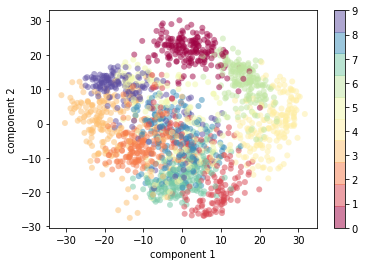

In [69]:
# We can now plot the first two principal components of each point to learn about the data:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

## Choosing the number of components
A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

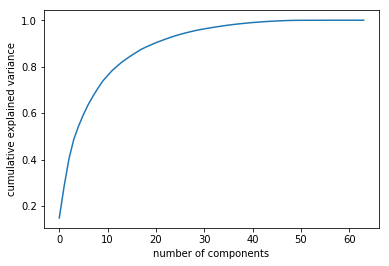

In [70]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first N components. For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance. Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

## Right order of doing feature selection, PCA and normalization?

If I were doing a classifier of some sort I would personally use this order

- Normalization
- PCA
- Feature Selection

Normalization: You would do normalization first to get data into reasonable bounds. If you have data (x,y) and the range of x is from -1000 to +1000 and y is from -1 to +1 You can see any distance metric would automatically say a change in y is less significant than a change in X. we don't know that is the case yet. So we want to normalize our data.

PCA: Uses the eigenvalue decomposition of data to find an orthogonal basis set that describes the variance in data points. If you have 4 characteristics, PCA can show you that only 2 characteristics really differentiate data points which brings us to the last step

Feature Selection: once you have a coordinate space that better describes your data you can select which features are salient.Typically you'd use the largest eigenvalues(EVs) and their corresponding eigenvectors from PCA for your representation. Since larger EVs mean there is more variance in that data direction, you can get more granularity in isolating features. This is a good method to reduce number of dimensions of your problem.

of course this could change from problem to problem, but that is simply a generic guide.

## Assessing Machine Learning Algorithms with PCA 

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [76]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

features = ['Alcohol', 'Malic acid', 'Ash', 'Alkalinity of ash',
       'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline']

x = wine.loc[:, features].values
y = wine.loc[:,['class']].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=123)

# scale
#std_scale = preprocessing.StandardScaler().fit(X_train)
#X_train = std_scale.transform(X_train)
#X_test = std_scale.transform(X_test)

# with-out PCA
print('features: without PCA', X_test.shape)

clsf1 = OneVsRestClassifier(SVC(kernel='rbf', C=1.0, random_state=1))
clsf1.fit(X_train, y_train) # train

clsf1.predict(X_test) # Predict 
print('mean accuracy:', clsf1.score(X_test, y_test)) # access performance (mean accuracy)


# with PCA

def withPCA(n_comp):
    print()
    
    # apply dimensionality reduction to both train and test
    x_train= PCA(n_components=n_comp).fit_transform(X_train)
    x_test= PCA(n_components=n_comp).fit_transform(X_test)

    clsf2 = OneVsRestClassifier(SVC(kernel='rbf', C=1.0, random_state=1))
    print('features: with PCA (n_components=%d)' %(n_comp), x_test.shape)
    clsf2.fit(x_train, y_train) # train

    clsf2.predict(x_test) # Predict 
    print('mean accuracy:', clsf2.score(x_test, y_test))# access performance (mean accuracy)
    
withPCA(2)
withPCA(4)
withPCA(6)
withPCA(7)
withPCA(8)


features: without PCA (54, 13)
mean accuracy: 0.37037037037037035

features: with PCA (n_components=2) (54, 2)
mean accuracy: 0.35185185185185186

features: with PCA (n_components=4) (54, 4)
mean accuracy: 0.35185185185185186

features: with PCA (n_components=6) (54, 6)
mean accuracy: 0.37037037037037035

features: with PCA (n_components=7) (54, 7)
mean accuracy: 0.37037037037037035

features: with PCA (n_components=8) (54, 8)
mean accuracy: 0.37037037037037035
